# Fine-tuning Alzheimer Detection Model

Este notebook realiza o fine-tuning do modelo de detecção de Alzheimer usando imagens de maior resolução.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Importar o modelo
from AlzheimerCNN import AlzheimerCNN

## Configuração dos Parâmetros

In [2]:
# Configurações
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20
IMAGE_SIZE = 512  # Aumentando a resolução para 512x512
NUM_CLASSES = 4

# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## Carregar o Modelo Pré-treinado

In [3]:
# Carregar o modelo pré-treinado
model = AlzheimerCNN(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load('alzheimer_mri_model.pth', map_location=device))
model = model.to(device)

# Congelar todas as camadas exceto a última
for param in model.parameters():
    param.requires_grad = False
    
# Descongelar a última camada (fc2)
for param in model.fc2.parameters():
    param.requires_grad = True

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18560\1703984441.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('alzheimer_mri_model.pth', 

## Preparação dos Dados

In [4]:
# Transformações para treinamento
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar dataset de treinamento
train_dataset = datasets.ImageFolder(
    root='datasets_fine_tuning/train',
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

print(f"Número de imagens de treinamento: {len(train_dataset)}")

Número de imagens de treinamento: 82916


## Configuração do Treinamento

In [5]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Listas para armazenar métricas
train_losses = []
train_accuracies = []

## Loop de Treinamento

In [6]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Atualizar barra de progresso
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })
    
    # Calcular métricas da época
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%')

Epoch 1/20: 100%|██████████| 5183/5183 [07:59<00:00, 10.81it/s, loss=0.865, acc=68.1]  


Epoch 1/20 - Loss: 0.8651 - Accuracy: 68.05%


Epoch 2/20: 100%|██████████| 5183/5183 [07:23<00:00, 11.69it/s, loss=0.656, acc=76.1]


Epoch 2/20 - Loss: 0.6557 - Accuracy: 76.14%


Epoch 3/20: 100%|██████████| 5183/5183 [07:04<00:00, 12.22it/s, loss=0.616, acc=77]  


Epoch 3/20 - Loss: 0.6154 - Accuracy: 77.04%


Epoch 4/20: 100%|██████████| 5183/5183 [06:40<00:00, 12.96it/s, loss=0.601, acc=77.1]


Epoch 4/20 - Loss: 0.6010 - Accuracy: 77.12%


Epoch 5/20: 100%|██████████| 5183/5183 [06:41<00:00, 12.92it/s, loss=0.594, acc=77]  


Epoch 5/20 - Loss: 0.5944 - Accuracy: 77.00%


Epoch 6/20: 100%|██████████| 5183/5183 [07:06<00:00, 12.14it/s, loss=0.589, acc=77.1]


Epoch 6/20 - Loss: 0.5891 - Accuracy: 77.09%


Epoch 7/20: 100%|██████████| 5183/5183 [06:58<00:00, 12.40it/s, loss=0.586, acc=77.1]


Epoch 7/20 - Loss: 0.5860 - Accuracy: 77.10%


Epoch 8/20: 100%|██████████| 5183/5183 [07:00<00:00, 12.33it/s, loss=0.583, acc=77.2]


Epoch 8/20 - Loss: 0.5830 - Accuracy: 77.22%


Epoch 9/20: 100%|██████████| 5183/5183 [06:59<00:00, 12.36it/s, loss=0.58, acc=77.1] 


Epoch 9/20 - Loss: 0.5796 - Accuracy: 77.12%


Epoch 10/20: 100%|██████████| 5183/5183 [07:03<00:00, 12.25it/s, loss=0.578, acc=77.4]


Epoch 10/20 - Loss: 0.5781 - Accuracy: 77.40%


Epoch 11/20: 100%|██████████| 5183/5183 [07:05<00:00, 12.18it/s, loss=0.578, acc=77.3]


Epoch 11/20 - Loss: 0.5778 - Accuracy: 77.27%


Epoch 12/20: 100%|██████████| 5183/5183 [07:25<00:00, 11.63it/s, loss=0.576, acc=77.2]


Epoch 12/20 - Loss: 0.5762 - Accuracy: 77.24%


Epoch 13/20: 100%|██████████| 5183/5183 [06:32<00:00, 13.22it/s, loss=0.577, acc=77.3]


Epoch 13/20 - Loss: 0.5767 - Accuracy: 77.27%


Epoch 14/20: 100%|██████████| 5183/5183 [06:25<00:00, 13.46it/s, loss=0.575, acc=77.4]


Epoch 14/20 - Loss: 0.5748 - Accuracy: 77.37%


Epoch 15/20: 100%|██████████| 5183/5183 [06:49<00:00, 12.66it/s, loss=0.574, acc=77.4]


Epoch 15/20 - Loss: 0.5744 - Accuracy: 77.35%


Epoch 16/20: 100%|██████████| 5183/5183 [06:37<00:00, 13.04it/s, loss=0.573, acc=77.4]


Epoch 16/20 - Loss: 0.5731 - Accuracy: 77.35%


Epoch 17/20: 100%|██████████| 5183/5183 [07:30<00:00, 11.51it/s, loss=0.575, acc=77.4]


Epoch 17/20 - Loss: 0.5752 - Accuracy: 77.43%


Epoch 18/20: 100%|██████████| 5183/5183 [08:18<00:00, 10.39it/s, loss=0.572, acc=77.4]


Epoch 18/20 - Loss: 0.5724 - Accuracy: 77.40%


Epoch 19/20: 100%|██████████| 5183/5183 [08:15<00:00, 10.46it/s, loss=0.572, acc=77.4]


Epoch 19/20 - Loss: 0.5720 - Accuracy: 77.39%


Epoch 20/20: 100%|██████████| 5183/5183 [08:22<00:00, 10.31it/s, loss=0.573, acc=77.4]

Epoch 20/20 - Loss: 0.5732 - Accuracy: 77.39%


## Visualização do Treinamento

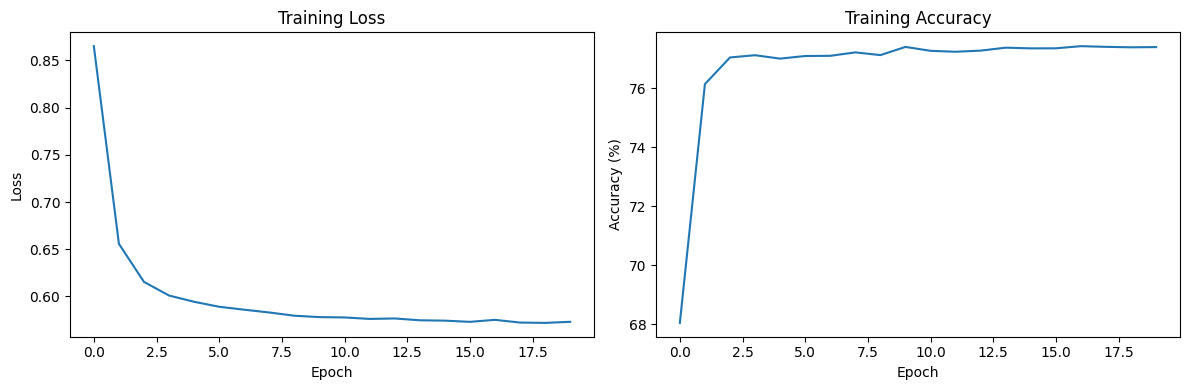

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

## Salvando o Modelo Fine-tuned

In [8]:
# Salvar o modelo
torch.save(model.state_dict(), 'alzheimer_mri_model_fine_tuned.pth')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!
